In [ ]:
!pip install -q kaggle
!kaggle datasets download -d noamaanabdulazeem/jmuben-coffee-dataset
!pip install albumentations opencv-python


Dataset URL: https://www.kaggle.com/datasets/noamaanabdulazeem/jmuben-coffee-dataset
License(s): unknown
100% 772M/773M [00:39<00:00, 23.7MB/s]
100% 773M/773M [00:39<00:00, 20.7MB/s]


In [ ]:
import zipfile
import os

with zipfile.ZipFile("jmuben-coffee-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("jmuben-coffee-dataset")

print("Dataset extracted successfully!")

Dataset extracted successfully!


Tổng số ảnh: 58549


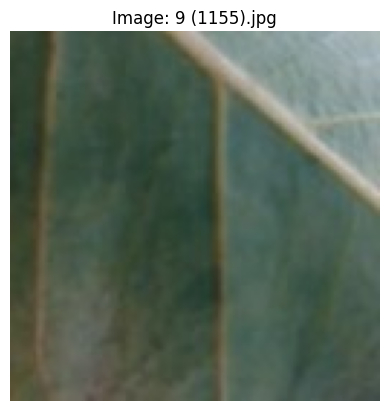

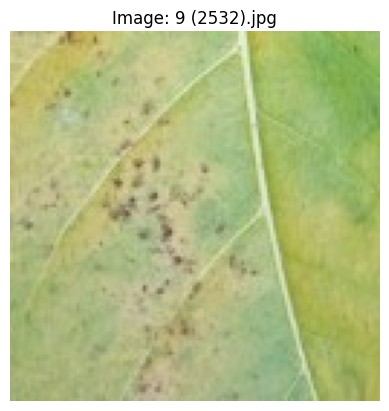

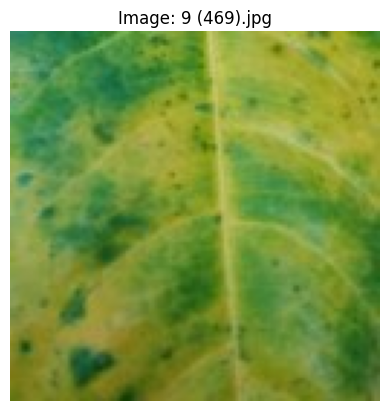

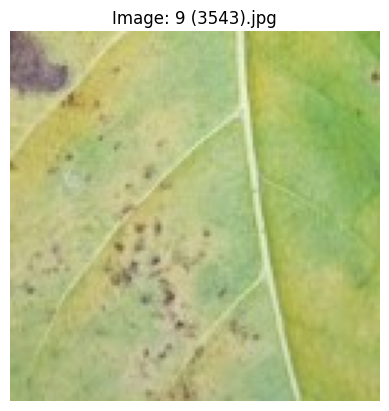

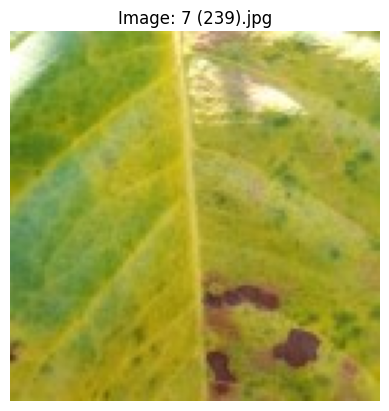

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Đường dẫn tới thư mục ảnh
data_dir = "/content/jmuben-coffee-dataset/JMuBEN"

# Lấy danh sách các tệp ảnh
image_files = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(os.path.join(root, file))

print(f"Tổng số ảnh: {len(image_files)}")

# Hiển thị một số ảnh mẫu
for i in range(5):
    img = Image.open(image_files[i])
    plt.imshow(img)
    plt.title(f"Image: {os.path.basename(image_files[i])}")
    plt.axis("off")
    plt.show()


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

# Biến đổi ảnh
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Tải toàn bộ tập dữ liệu
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Chia tập dữ liệu: 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Classes: {dataset.classes}")
print(f"Số lượng ảnh trong tập train: {len(train_dataset)}")
print(f"Số lượng ảnh trong tập test: {len(test_dataset)}")


Classes: ['Cerscospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma']
Số lượng ảnh trong tập train: 46839
Số lượng ảnh trong tập test: 11710


In [ ]:
# 4. Tạo các thư mục lưu trữ tập train và test
output_dir = "processed-dataset"
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# 5. Hàm lưu ảnh
def save_images(dataset, output_dir):
    for idx, (img, label) in enumerate(dataset):
        class_name = dataset.dataset.classes[label]
        class_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        # Lưu hình ảnh
        img_path = os.path.join(class_dir, f"image_{idx}.jpg")
        img = transforms.ToPILImage()(img)  # Chuyển tensor sang PIL Image
        img.save(img_path)

# 6. Lưu tập train và test
print("Đang lưu tập train...")
save_images(train_dataset, train_dir)
print("Tập train đã được lưu!")

print("Đang lưu tập test...")
save_images(test_dataset, test_dir)
print("Tập test đã được lưu!")

print("Hoàn tất!")

Đang lưu tập train...
Tập train đã được lưu!
Đang lưu tập test...
Tập test đã được lưu!
Hoàn tất!


In [ ]:
import os
import cv2
import albumentations as A
from albumentations.core.composition import OneOf
from tqdm import tqdm

# Đường dẫn đến thư mục dữ liệu
train_dir = "/content/processed-dataset/train"
output_dir = "/content/processed-dataset/train_augmented"

# Tạo thư mục đầu ra nếu chưa tồn tại
os.makedirs(output_dir, exist_ok=True)

# Định nghĩa các phép tăng cường dữ liệu
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),               # Lật ngang
    A.RandomBrightnessContrast(p=0.2),    # Điều chỉnh độ sáng và tương phản
    A.Rotate(limit=30, p=0.5),            # Xoay ngẫu nhiên trong khoảng -30 đến 30 độ
    A.GaussNoise(p=0.2),                  # Thêm nhiễu Gaussian
])

# Hàm tăng cường dữ liệu cho từng hình ảnh
def augment_and_save(image_path, save_dir, num_augments=5):
    # Đọc hình ảnh
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Tên gốc của ảnh
    base_name = os.path.splitext(os.path.basename(image_path))[0]

    # Tạo và lưu ảnh tăng cường
    for i in range(num_augments):
        augmented = augmentations(image=image)
        augmented_image = augmented['image']
        save_path = os.path.join(save_dir, f"{base_name}_aug{i+1}.jpg")
        cv2.imwrite(save_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

# Thực hiện tăng cường dữ liệu cho tất cả ảnh trong tập train
for class_folder in tqdm(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        # Tạo thư mục đầu ra cho từng lớp
        output_class_dir = os.path.join(output_dir, class_folder)
        os.makedirs(output_class_dir, exist_ok=True)

        # Tăng cường dữ liệu cho từng ảnh trong lớp
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            augment_and_save(image_path, output_class_dir)


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
100%|██████████| 5/5 [08:36<00:00, 103.39s/it]


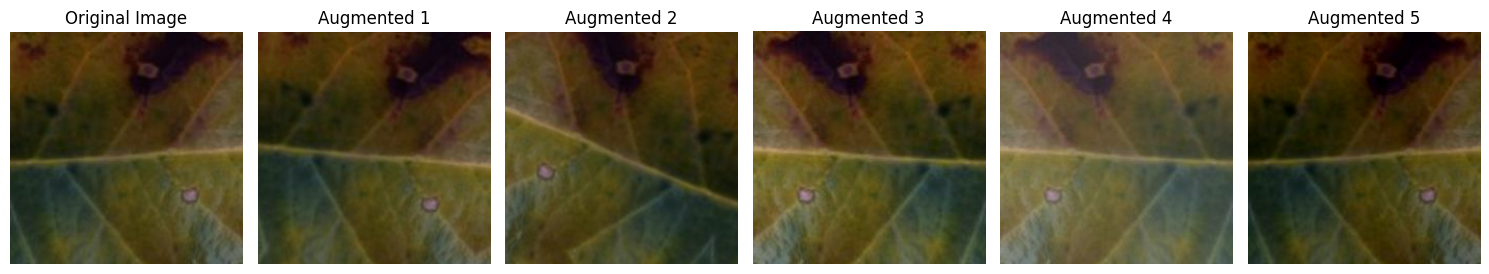

In [ ]:
import matplotlib.pyplot as plt

# Hàm hiển thị ảnh gốc và ảnh tăng cường
def show_augmentation_example(image_path, augmentations, num_examples=3):
    """
    Hiển thị ảnh gốc và một vài ví dụ ảnh đã tăng cường.

    Args:
        image_path (str): Đường dẫn đến ảnh gốc.
        augmentations (albumentations.Compose): Phép tăng cường dữ liệu.
        num_examples (int): Số lượng ảnh tăng cường để hiển thị.
    """
    # Đọc ảnh gốc
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Tăng cường dữ liệu
    augmented_images = []
    for _ in range(num_examples):
        augmented = augmentations(image=image)
        augmented_images.append(augmented['image'])

    # Hiển thị ảnh gốc và ảnh tăng cường
    plt.figure(figsize=(15, 5))
    plt.subplot(1, num_examples + 1, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    for i, aug_image in enumerate(augmented_images):
        plt.subplot(1, num_examples + 1, i + 2)
        plt.imshow(aug_image)
        plt.title(f"Augmented {i + 1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Ví dụ sử dụng hàm hiển thị
example_image_path = "/content/processed-dataset/train/Cerscospora/image_0.jpg"  # Thay bằng đường dẫn ảnh thực tế
show_augmentation_example(example_image_path, augmentations, num_examples=5)
